# 🧠 Análisis de Nota Económica – NLP en Python

## 📌 Introducción

Este notebook presenta un análisis de lenguaje natural (NLP) aplicado a una nota publicada en el diario *La Nación* el **29 de junio de 2025**, escrita por **José Del Río**. El artículo se enfoca en el estado de ánimo y las preocupaciones de distintos referentes empresariales frente a la coyuntura económica argentina.

A través del uso de herramientas de NLP en Python, exploraremos el contenido de la nota para extraer patrones, reducir el texto a sus componentes esenciales y medir su carga emocional o polaridad.

## 🎯 Objetivos

- Preprocesar el texto mediante tokenización, lematización y remoción de stopwords.
- Extraer tokens relevantes del artículo y visualizar palabras frecuentes.
- Realizar un análisis de sentimientos o polaridad del texto completo.
- Observar las distintas opiniones expresadas por 5 referentes clave:
  - **Javier Bolzico**, presidente de Adeba (sector bancario).
  - **Gustavo Weiss**, titular de Camarco (infraestructura).
  - **Issel Kiperszmid**, vicepresidente de la CEDU (desarrollos inmobiliarios).
  - **Martín Rapallini**, presidente de la Unión Industrial Argentina (industria nacional).
  - **Mario Grinman**, titular de la Cámara Argentina de Comercio (comercio y servicios).

Estos representantes, junto con la Bolsa y la Sociedad Rural Argentina, forman un termómetro de los sectores más relevantes del país.

## 🔗 Fuente del artículo

[Plan económico: ¿cuál es el verdadero riesgo que preocupa a los empresarios? (La Nación)](https://www.lanacion.com.ar/economia/plan-economico-cual-es-el-verdadero-riesgo-que-preocupa-a-los-empresarios-nid29062025/)

## 🧰 Librerías necesarias

Este proyecto utiliza una serie de bibliotecas de Python especializadas en procesamiento de lenguaje natural, visualización y análisis de datos:

- **spaCy**: Para tokenización, lematización y etiquetado gramatical (POS) del texto en español.
- **nltk**: Para la gestión de *stopwords* (palabras vacías comunes en español).
- **textblob**: Para análisis básico de sentimientos (polaridad y subjetividad).
- **pysentimiento**: Biblioteca basada en modelos BERT que permite realizar análisis de sentimientos específicamente en español.
- **matplotlib**: Para generar gráficos y visualizaciones básicas.
- **seaborn**: Para visualizaciones estadísticas mejoradas.
- **wordcloud**: Para crear nubes de palabras a partir de los tokens más frecuentes.
- **pandas**: Para manipulación y análisis de datos tabulares.
- **numpy**: Para operaciones numéricas y estructuras eficientes de datos.

> 💡 Asegúrate de tener cargado el modelo de idioma español de spaCy (`es_core_news_sm`) y de haber descargado los corpora necesarios para TextBlob ejecutando:
>
> ```bash
> python -m spacy download es_core_news_sm
> python -m textblob.download_corpora
> ```

In [1]:
# Procesamiento de lenguaje natural
import spacy
import nltk
from nltk.corpus import stopwords

# Descargar stopwords de NLTK
nltk.download('stopwords')

# Análisis de sentimientos
from textblob import TextBlob
from pysentimiento import create_analyzer

# Visualización
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Análisis y manipulación de datos
import pandas as pd
import numpy as np

# Descargar modelo de spaCy en español si aún no está cargado
nlp = spacy.load("es_core_news_sm")

# Descargar los corpora necesarios para textblob desde consola
!python -m textblob.download_corpora

d:\news_articule_analysis\env\Lib\site-packages\nltk\metrics\association.py:26: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import fisher_exact
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
d:\news_articule_analysis\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finished.


d:\news_articule_analysis\env\Lib\site-packages\nltk\metrics\association.py:26: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import fisher_exact
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\George

## 📥 Carga del texto

Para trabajar con el contenido del artículo periodístico, primero cargamos el texto desde un archivo local llamado `economic_article-2025-06-29.txt`. Este archivo contiene la nota completa publicada en el diario *La Nación* el 29 de junio de 2025, escrita por José Del Río.

El archivo debe estar ubicado en el mismo directorio que este notebook o se debe indicar la ruta relativa correspondiente.

Una vez cargado, el contenido se guarda en la variable `texto` para su posterior análisis.

In [2]:
# Leer el texto desde el archivo .txt
with open("economic_article-2025-06-29.txt", "r", encoding="utf-8") as file:
    texto = file.read()

# Ver los primeros 500 caracteres del texto para verificar
print(texto[:500])

Plan económico. Cuál es el verdadero riesgo que preocupa a los empresarios?
El debate es cada vez más explícito; la brecha entre la macro y la micro está a flor de piel; cuáles son las reformas que esperan y porqué tienen la mira en el empleo y la actividad; cuál es el país que corre por las venas de quienes hacen negocios en la Argentina desde hace muchos años; las expectativas sobre el dólar y el dilema de la competitividad.
Fueron tres cafés negros y un cortado. La charla se extendió por 60 m


## 🧹 Preprocesamiento del texto

Antes de realizar cualquier análisis, es necesario limpiar y estructurar el texto para facilitar su interpretación computacional. En este paso aplicamos varias técnicas de procesamiento de lenguaje natural (NLP):

- **Conversión a minúsculas**: Unificamos todo el texto para evitar diferencias entre palabras idénticas por su uso de mayúsculas.

- **Tokenización**: Dividimos el texto en unidades lingüísticas mínimas llamadas *tokens* (generalmente palabras).

- **Lematización**: Reducimos cada palabra a su forma base o *lema* (por ejemplo, "tenían" → "tener").

- **Eliminación de stopwords**: Quitamos palabras vacías o muy frecuentes que no aportan valor semántico al análisis (como “el”, “y”, “de”).

- **Filtro de puntuación y tokens no alfabéticos**: Se descartan signos de puntuación, números y palabras no alfabéticas para centrarnos en contenido relevante.

El resultado de este proceso es una lista de palabras limpias y lematizadas que nos servirá como base para el análisis de frecuencia y sentimiento.

### Tokenización

In [3]:
# Procesar el texto
doc = nlp(texto)

print("✅ Texto procesado con spaCy")
print("Ejemplo de tokens:")
print([token.text for token in doc[:20]])

✅ Texto procesado con spaCy
Ejemplo de tokens:
['Plan', 'económico', '.', 'Cuál', 'es', 'el', 'verdadero', 'riesgo', 'que', 'preocupa', 'a', 'los', 'empresarios', '?', '\n', 'El', 'debate', 'es', 'cada', 'vez']


### Eliminar Signos de Puntuación

In [4]:
# Extraer solo los tokens que son palabras (sin puntuación, números, etc.)
tokens = [token for token in doc if token.is_alpha]

print("✅ Tokens alfabéticos extraídos:")
print([t.text for t in tokens[:20]])

✅ Tokens alfabéticos extraídos:
['Plan', 'económico', 'Cuál', 'es', 'el', 'verdadero', 'riesgo', 'que', 'preocupa', 'a', 'los', 'empresarios', 'El', 'debate', 'es', 'cada', 'vez', 'más', 'explícito', 'la']


### Convertir a Minúsculas

In [5]:
tokens_minuscula = [token.text.lower() for token in tokens]

print("✅ Tokens en minúscula:")
print(tokens_minuscula[:20])

✅ Tokens en minúscula:
['plan', 'económico', 'cuál', 'es', 'el', 'verdadero', 'riesgo', 'que', 'preocupa', 'a', 'los', 'empresarios', 'el', 'debate', 'es', 'cada', 'vez', 'más', 'explícito', 'la']


### Lematización

In [6]:
tokens_lematizados = [token.lemma_ for token in tokens]

print("✅ Tokens lematizados:")
print(tokens_lematizados[:20])

✅ Tokens lematizados:
['Plan', 'económico', 'cuál', 'ser', 'el', 'verdadero', 'riesgo', 'que', 'preocupar', 'a', 'el', 'empresario', 'el', 'debate', 'ser', 'cada', 'vez', 'más', 'explícito', 'el']


### Eliminado de Stop Words

In [7]:
stop_words = set(stopwords.words('spanish'))

# Usamos los lemas en minúscula
tokens_finales = [lemma.lower() for lemma in tokens_lematizados if lemma.lower() not in stop_words]

print("✅ Tokens limpios (lematizados, minúscula, sin stopwords):")
print(tokens_finales[:50])

✅ Tokens limpios (lematizados, minúscula, sin stopwords):
['plan', 'económico', 'cuál', 'ser', 'verdadero', 'riesgo', 'preocupar', 'empresario', 'debate', 'ser', 'cada', 'vez', 'explícito', 'brecha', 'macro', 'micro', 'flor', 'piel', 'cuál', 'ser', 'reforma', 'esperar', 'porqué', 'tener', 'mira', 'empleo', 'actividad', 'cuál', 'ser', 'país', 'correr', 'vena', 'hacer', 'negocio', 'argentina', 'hacer', 'año', 'expectativa', 'dólar', 'dilema', 'competitividad', 'ser', 'tres', 'café', 'negro', 'cortado', 'charla', 'extender', 'minuto', 'eufemismo']


## 🔡 Frecuencia de Palabras

Para identificar los temas centrales del artículo, realizamos un análisis de frecuencia de palabras.

### ¿Qué hacemos?
- Eliminamos palabras vacías (stopwords), signos de puntuación y convertimos todo a minúsculas.
- Lematizamos las palabras para agrupar variaciones (por ejemplo, "trabajando" → "trabajar").
- Contamos la frecuencia de aparición de cada palabra limpia.

### Visualización
Representamos los resultados de dos formas:
- 📊 **Gráfico de barras**: muestra las palabras más frecuentes de manera clara y cuantitativa.
- ☁️ **Nube de palabras (WordCloud)**: una visualización estética donde el tamaño de cada palabra refleja su frecuencia relativa en el texto.

Estas herramientas permiten explorar rápidamente los conceptos más repetidos y relevantes dentro del artículo.

C:\Users\George\AppData\Local\Temp\ipykernel_588\359275448.py:15: UserWarning: Glyph 128288 (\N{INPUT SYMBOL FOR LATIN CAPITAL LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\news_articule_analysis\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128288 (\N{INPUT SYMBOL FOR LATIN CAPITAL LETTERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


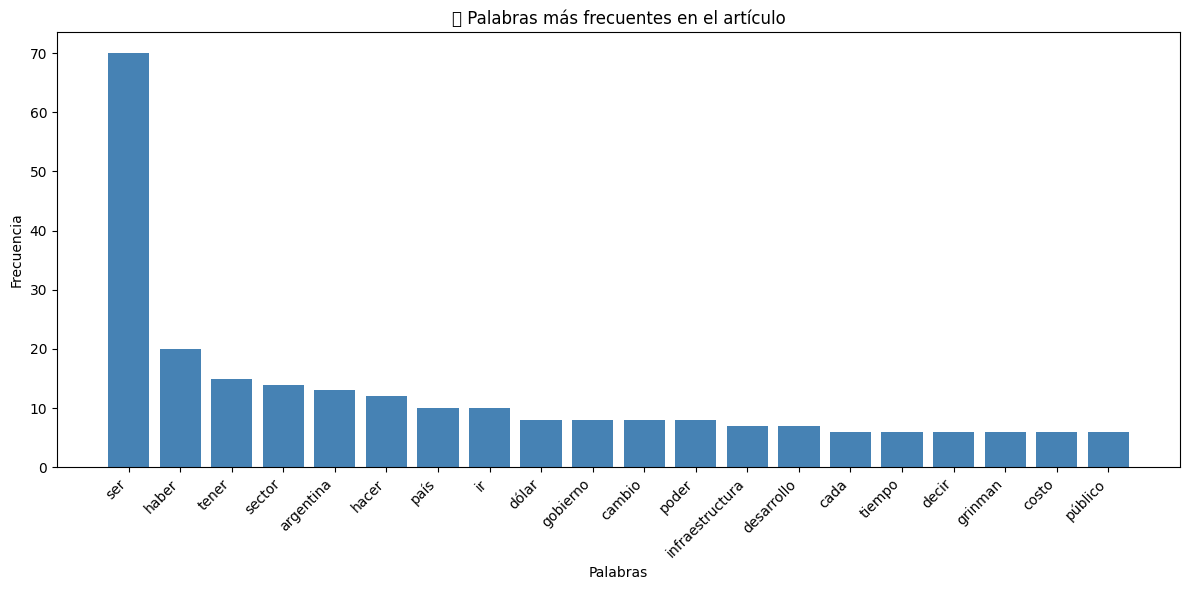

In [9]:
# Contar frecuencia de las palabras
frecuencias = Counter(tokens_finales)

# Obtener las 20 palabras más comunes
mas_comunes = frecuencias.most_common(20)
palabras, conteos = zip(*mas_comunes)

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(palabras, conteos, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.title("🔠 Palabras más frecuentes en el artículo")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

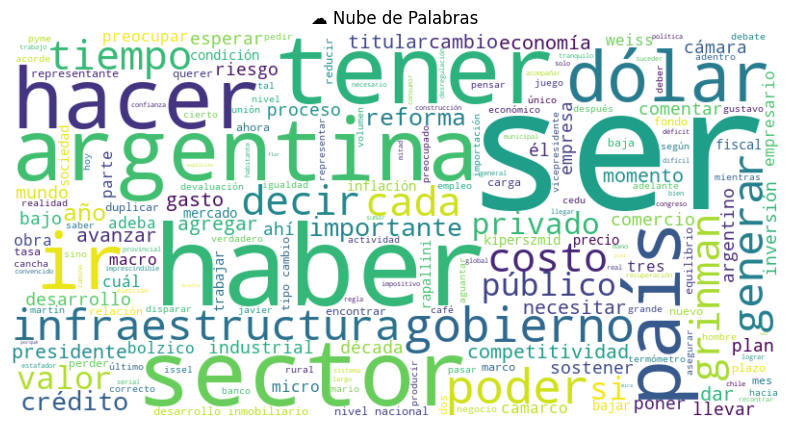

In [10]:
# Unir tokens en un solo texto
texto_unido = " ".join(tokens_finales)

# Crear y mostrar WordCloud
nube = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto_unido)

plt.figure(figsize=(10, 5))
plt.imshow(nube, interpolation='bilinear')
plt.axis("off")
plt.title("☁️ Nube de Palabras")
plt.show()

## 📝 Análisis de frecuencia excluyendo verbos

En este análisis vamos a **eliminar los verbos** del texto antes de calcular la frecuencia de palabras y generar la nube de palabras.

¿Por qué sacar los verbos?

- Los verbos expresan acciones y procesos, pero suelen ser muy frecuentes y generales, lo que puede opacar términos más representativos del contenido.
- Al excluirlos, nos enfocamos en sustantivos, adjetivos y otros términos que suelen reflejar mejor los conceptos, ideas y temas principales del artículo.
- Esto permite identificar con mayor claridad cuáles son los conceptos más relevantes y repetidos en el texto, facilitando la comprensión de los puntos clave que se tratan.

Así, podemos obtener una visión más clara de los temas centrales sin la "interferencia" de los verbos comunes.

In [19]:
# Procesamos el texto con spaCy
doc = nlp(texto)

# Lista de stopwords en español (usando nltk)
stop_words = set(stopwords.words('spanish'))

# Extraemos solo tokens que:
# - Son alfabéticos
# - NO son verbos (ni auxiliares)
# - NO están en las stopwords
# - Se lematizan y se transforman a minúsculas
tokens_sin_verbos = [
    token.lemma_.lower()
    for token in doc
    if token.is_alpha
    and token.pos_ not in ["VERB", "AUX"]  # <- eliminamos también los auxiliares
    and token.lemma_.lower() not in stop_words
]

print(tokens_sin_verbos[:30])


['plan', 'económico', 'cuál', 'verdadero', 'riesgo', 'empresario', 'debate', 'cada', 'vez', 'explícito', 'brecha', 'macro', 'micro', 'flor', 'piel', 'cuál', 'reforma', 'porqué', 'mira', 'empleo', 'actividad', 'cuál', 'país', 'vena', 'negocio', 'argentina', 'año', 'expectativa', 'dólar', 'dilema']


C:\Users\George\AppData\Local\Temp\ipykernel_588\257990840.py:13: UserWarning: Glyph 128289 (\N{INPUT SYMBOL FOR LATIN SMALL LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


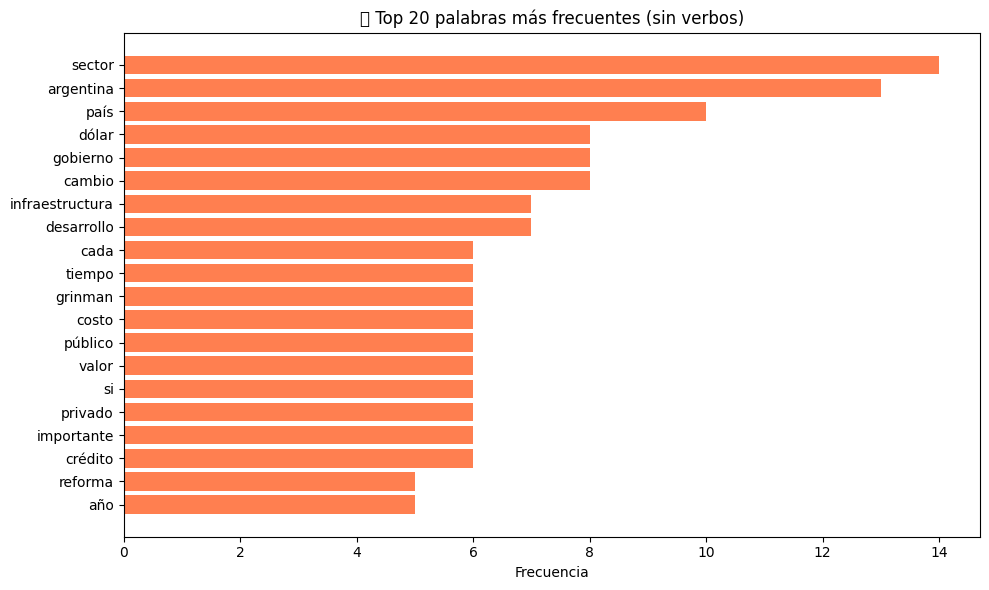

In [20]:
# Contar las palabras más frecuentes
frecuencias = Counter(tokens_sin_verbos)
mas_comunes = frecuencias.most_common(20)

# Separar las palabras y sus frecuencias
palabras, cantidades = zip(*mas_comunes)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(palabras[::-1], cantidades[::-1], color="coral")
plt.title("🔡 Top 20 palabras más frecuentes (sin verbos)")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

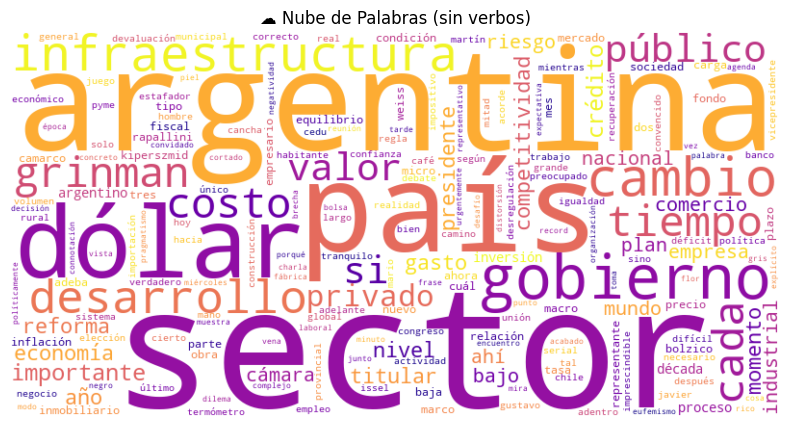

In [21]:
# Crear texto unido
texto_filtrado = " ".join(tokens_sin_verbos)

# Generar la nube
nube = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate(texto_filtrado)

# Mostrar
plt.figure(figsize=(10, 5))
plt.imshow(nube, interpolation='bilinear')
plt.axis("off")
plt.title("☁️ Nube de Palabras (sin verbos)")
plt.show()

## ❤️ Análisis de Sentimientos en Español con PySentimiento

El análisis de sentimientos permite identificar si un texto expresa emociones **positivas**, **negativas** o **neutras**.

En este proyecto utilizamos:

- **PySentimiento**: una librería basada en modelos BERT entrenados en español. Permite realizar análisis de sentimientos sin necesidad de traducir el texto. Ideal para evaluar discursos, noticias o declaraciones en su idioma original.

Podemos aplicar este análisis a:
- El artículo completo
- Fragmentos por párrafo o por referente (ej: opiniones de Rapallini, Grinman, Bolzico, etc.)

Esto nos ayuda a detectar diferencias en el tono emocional según el sector económico y la perspectiva del actor entrevistado.

In [10]:
# Unir los tokens limpios en un solo string
texto_limpio = " ".join(tokens_finales)

# Analizar el sentimiento del texto limpio
resultado = analyzer.predict(texto_limpio)

print("🔍 Sentimiento detectado:", resultado.output)
print("📊 Probabilidades:", resultado.probas)

🔍 Sentimiento detectado: NEU
📊 Probabilidades: {'NEG': 0.16055700182914734, 'NEU': 0.7964048385620117, 'POS': 0.04303819313645363}


Aplicando el modelo de análisis de sentimientos de `pysentimiento` en español al texto completo del artículo, se obtuvo el siguiente resultado:

- **🔍 Sentimiento detectado:** `NEU` (Neutral)
- **📊 Probabilidades:**
  - Negativo (`NEG`): 16.05%
  - Neutral (`NEU`): 79.64%
  - Positivo (`POS`): 4.30%

El modelo interpreta que el artículo mantiene un **tono predominantemente neutral**, lo cual es coherente con el estilo periodístico del texto. Aunque se abordan **temas sensibles** como la falta de competitividad, el gasto público o la preocupación empresarial, el tono general no es marcadamente emocional.

Algunas observaciones que se pueden llevar a cabo>
- La **baja puntuación positiva** (4.3%) sugiere que el artículo contiene **pocos mensajes de optimismo** o entusiasmo.
- La **presencia de tono negativo** (16%) indica cierta preocupación o crítica, especialmente en relación a temas económicos y políticos.
- El alto porcentaje neutral (79.6%) refleja un lenguaje técnico, informativo y balanceado, que presenta opiniones diversas sin cargar emocionalmente el discurso.